# Installation

In [1]:
%pip install transformer_lens
%pip install einops
%pip install plotly
%pip install jaxtyping
%pip install protobuf==3.20.*
%pip install pytorch_lightning
%pip install pytorch
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install circuitsvis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-8nyyj0d3/pytorch_fccb40554cf549f598588828bc1a2551/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch

Failed to build pytorch
  Running setup.py install for pytorch ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-8nyyj0d3/pytorch_fccb40554cf549f598588828bc1a2551/setup.py", line 11, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.
Note: you may need to restart the kernel to use updated packages.
Note:

# Setup

## Imports

In [194]:
#import statements
import torch 
import numpy as np
from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, clear_output, Image as IPyImage
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import functools
from transformer_lens import utils
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import plotly.io as pio
import circuitsvis as cv
from PIL import Image


pio.renderers.default = "png"

## Function Definitions

### Nice Normal Functions

In [3]:
def generate_digit_dataset(n_examples, n_digits, reversed_output=False, n_equals=0):
    # Generate a dataset of equations that involve an addition between two numbers with n_digits
    assert n_examples <= 10 ** (n_digits * 2)
    dataset = set()
    while len(dataset) != n_examples:
        # Sample random numbers
        a = np.random.randint(0, 10**n_digits)
        b = np.random.randint(0, 10**n_digits)
        dataset.add(generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals))
    return list(dataset)

def generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals):
    bos = ''
    sep = '=' * n_equals
    a_fwd = f'{a:>0{n_digits}d}'
    b_fwd = f'{b:>0{n_digits}d}'
    c_fwd = f'{a+b:>0{n_digits+1}d}'
    if reversed_output:
        return f"{bos}{a_fwd[::-1]}{b_fwd[::-1]}{sep}{c_fwd[::-1]}"
    else:
        return f"{bos}{a_fwd}{b_fwd}{sep}{c_fwd}"

def tokenize_strings(strings):
    vocab = "0123456789=^"
    vocab2idx = {v: i for i, v in enumerate(vocab)}
    # Tokenize a list of strings
    tokens = np.zeros((len(strings), len(strings[0])), dtype=np.int64)
    for i, string in enumerate(strings):
        idxs = [vocab2idx[char] for char in list(string)]
        tokens[i] = np.array(idxs)
    return tokens

class TokenizedDataset(torch.utils.data.Dataset):

    def __init__(self, tokens):
        # Tokens should be of shape N_examples x N_chars x D_tokens
        self.tokens = torch.tensor(tokens).long()

    def __getitem__(self, index):
        # Should return an example of N_chars x D_tokens
        return self.tokens[index]

    def __len__(self):
        return self.tokens.shape[0]

In [4]:
def construct_model(n_layers, n_heads, d_head, attn_only=False, disable_b=False):
    # Create a HookedTransformer
    print(f'construct_model n_heads={n_heads}, d_head={d_head}')
    cfg = HookedTransformerConfig(
        n_layers=n_layers,
        n_heads=n_heads,
        d_model=128,
        d_head=d_head,
        d_mlp=512 if not attn_only else None,
        act_fn="gelu" if not attn_only else None,
        attn_only=attn_only,
        normalization_type=None,
        attention_dir="causal",
        d_vocab=12,
        d_vocab_out=10,
        n_ctx=3*n_digits+1+n_equals, # Create appropriate context size for strings
        init_weights=True,
        device="cuda"
    )
    model = HookedTransformer(cfg)
    if disable_b:
        for name, param in model.named_parameters():
            if "b_" in name:
                param.requires_grad = False
    return model

def loss_fn(logits, labels):
    # Logits is shape B x P x D, labels is B x P
    log_probs = logits.reshape(-1, logits.shape[-1]).log_softmax(dim=-1)
    labels = labels.reshape(-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()

def acc_fn(logits, labels):
    with torch.no_grad():
        # We can't differentiate this
        preds = logits.argmax(dim=-1)
        correct = preds == labels
        return torch.sum(correct).item() / np.prod(correct.shape)


def train_model(model, train_loader, test_loader, n_epochs, verbose=False,):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, ) #betas=(0.9, 0.98), weight_decay=1.,)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    train_acc = []
    test_acc = []
    
    epoch_tqdm = tqdm(total=n_epochs, desc='Training model', leave=True)
    loss_plot = widgets.Output()

    # Display widgets
    display(epoch_tqdm)
    display(loss_plot)

    for epoch in range(n_epochs):
        epoch_tqdm.update(1) # update progress bar

        acc = []
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            n_batch, n_pos = batch.shape
            cutoff = n_pos - n_digits - 1
            X = torch.cat((batch[:, :cutoff], 10 * torch.ones(n_batch, n_digits + 1, dtype=torch.long)), dim=1).cuda() # Pad with = where the output should be
            labels = batch[:, cutoff:].cuda()
            logits = model(X)[:, cutoff:]
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            acc.append(acc_fn(logits, labels))
        train_acc.append(np.array(acc).mean())


        acc = []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                n_batch, n_pos = batch.shape
                cutoff = n_pos - n_digits - 1
                X = torch.cat((batch[:, :cutoff], 10 * torch.ones(n_batch, n_digits + 1, dtype=torch.long)), dim=1).cuda()
                labels = batch[:, cutoff:].cuda()
                logits = model(X)[:, cutoff:]
                acc.append(acc_fn(logits, labels))
        test_acc.append(np.array(acc).mean())

        scheduler.step()
        if verbose:
            print(f"Epoch: {epoch + 1}, Train Acc: {train_acc[-1]*100:.3f}%, Test Acc: {test_acc[-1]*100:.3f}%")
        with loss_plot:
            plt.clf() # clear current figure
            plt.plot(train_acc, label='Train acc')
            plt.plot(test_acc, label='Test acc')
            plt.title('Accuracy over Time')
            plt.xlabel('Iteration')
            plt.ylabel('Accuracy')
            plt.legend()
            clear_output(wait=True)
            display(plt.gcf()) # display current figure
            plt.close() # close current figure to free memory

    return train_acc, test_acc

### Evil interactivity functions that use globals

In [5]:
def configure_and_train(
    _n_digits,
    _reversed_output,
    _n_equals,
    _n_heads,
    _d_head,
    _n_train_set,
    _n_test_set,
    _batch_size,
    _n_epochs
):
    global n_digits, reversed_output, n_equals, n_train_set, n_test_set, batch_size, n_epochs, n_heads, d_head
    global strings, tokens, train_set, test_set
    global train_loader, test_loader
    global model
    global train_acc, test_acc
    
    n_digits        = _n_digits
    reversed_output = _reversed_output
    n_equals        = _n_equals
    n_heads         = _n_heads
    d_head          = _d_head
    n_train_set     = _n_train_set
    n_test_set      = _n_test_set
    batch_size      = _batch_size
    n_epochs        = _n_epochs

    strings   = generate_digit_dataset(n_train_set + n_test_set, n_digits, reversed_output, n_equals)
    tokens    = tokenize_strings(strings)
    train_set = TokenizedDataset(tokens[:n_train_set])
    test_set  = TokenizedDataset(tokens[n_train_set:])

    # Create Dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # And then actually train the model
    model = construct_model(1, n_heads=n_heads, d_head=d_head, attn_only=True)
    train_acc, test_acc = train_model(model, train_loader, test_loader, n_epochs, verbose=False)

    print(f"Train acc: {train_acc[-1]}")
    print(f"Test acc: {test_acc[-1]}")

In [6]:
def view_attn_pattern(a=1234, b=1234):
    global model, n_digits, reversed_output, n_equals
    
    input_str = generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals)
    tokens = tokenize_strings([input_str,])

    _,size = tokens.shape
    string_tokens = []
    for i in range(size):
      string_tokens.append(str(tokens[0][i]))
    print(string_tokens)
    tokens = torch.tensor(tokens).long().cuda()
    output = model(tokens).argmax(2)

    print("Here is the output",output[0, -(n_digits+1):])

    logits, cache = model.run_with_cache(tokens)
    html = cv.attention.attention_patterns(
        tokens = string_tokens,
        attention=cache["pattern", 0][0]
    )

    return display(html)

# Training

In [7]:
# Set the defaults
n_digits        = 6
reversed_output = True
n_equals        = 0
n_heads         = 32
d_head          = 2
n_train_set     = 25_000
n_test_set      = 2_000
batch_size      = 256
n_epochs        = 1000

# Configure the training run the first time, so that just running the notebook end
# to end works
configure_and_train(
    n_digits,
    reversed_output,
    n_equals,
    n_heads,
    d_head,
    n_train_set,
    n_test_set,
    batch_size,
    n_epochs
)

construct_model n_heads=32, d_head=2


Training model:   0%|          | 0/1000 [00:00<?, ?it/s]

Output()

Train acc: 0.9845360824742269
Test acc: 0.9795121173469388


In [8]:
# And then allow the user to configure it for later runs
interact_manual.options(manual_name="Retrain model")(
    configure_and_train,
    _n_digits        = widgets.BoundedIntText(value=n_digits, min=1, max=12),
    _reversed_output = widgets.Checkbox(value=reversed_output),
    _n_equals        = widgets.BoundedIntText(value=n_equals, min=0, max=3),
    _n_heads         = widgets.BoundedIntText(value=n_heads, min=1, max=32),
    _d_head          = widgets.BoundedIntText(value=d_head, min=1, max=128),
    _n_train_set     = widgets.BoundedIntText(value=n_train_set, min=1, max=1_000_000),
    _n_test_set      = widgets.BoundedIntText(value=n_test_set, min=1, max=1_000_000),
    _batch_size      = widgets.BoundedIntText(value=batch_size, min=1, max=65_536),
    _n_epochs        = widgets.BoundedIntText(value=n_epochs, min=1, max=10_000)
)

interactive(children=(BoundedIntText(value=6, description='_n_digits', max=12, min=1), Checkbox(value=True, de…

<function __main__.configure_and_train(_n_digits, _reversed_output, _n_equals, _n_heads, _d_head, _n_train_set, _n_test_set, _batch_size, _n_epochs)>

In [9]:
interact_manual(
    view_attn_pattern,
    a=widgets.BoundedIntText(value=1234, min=0, max=999999),
    b=widgets.BoundedIntText(value=1234, min=0, max=999999),
)



interactive(children=(BoundedIntText(value=1234, description='a', max=999999), BoundedIntText(value=1234, desc…

<function __main__.view_attn_pattern(a=1234, b=1234)>

# Logit Attribution

In [162]:
def hook_function(pattern, hook, head_index_not_to_ablate, n_heads=4):
    for k in range(n_heads):
        if (k != head_index_not_to_ablate):
            pattern[:, :, k, :] = 0.0
    return pattern

def hook_function_zero_ablate_all_heads(pattern, hook, n_heads):
    for k in range(n_heads):
        pattern[:, :, k, :] = 0.0
    return pattern

def get_ablation_score_without_attn(model, tokens):
    model.reset_hooks()
    return model.run_with_hooks(tokens, fwd_hooks=[
        (utils.get_act_name('v', 0), functools.partial(
            hook_function_zero_ablate_all_heads,
            n_heads=model.cfg.n_heads
        ))
    ])

def get_ablation_scores(
    model,
    tokens
):
    '''
    Returns a tensor of shape (n_layers, n_heads) containing the increase in cross entropy loss from ablating the output of each head.
    '''
    ablation_scores = []

    # Calculating loss without any ablation, to act as a baseline
    model.reset_hooks()
    #logits = model(tokens)
    #print("Here are the actual logits")
    #print(logits[0][-(n_digits+ 1):].argmax(-1))

    for head in range(model.cfg.n_heads):
            # Use functools.partial to create a temporary hook function with the head number fixed
        temp_hook_fn = functools.partial(hook_function, head_index_not_to_ablate=head, n_heads=model.cfg.n_heads)
            # Run the model with the ablation hook
        ablated_logits = model.run_with_hooks(tokens, fwd_hooks=[
            (utils.get_act_name("v",0), temp_hook_fn)
        ])
            
        #return the ablated logits for each score
        ablation_scores.append(ablated_logits)

    return ablation_scores


#for consecutive pairs of numbers (01), (12) ... (89), we see which heads boost up the likelihood of the correct logit
list_tokens= []
list_output= []
list_correct_logits = []

for i in range(9):
#    input_str = f"{str(i).zfill(n_digits)}{str(i+1).zfill(n_digits)}{(n_equals+n_digits+1) * '='}"
    input_str = generate_digit_datapoint(i, i+1, n_digits, reversed_output, n_equals)
    tokens = tokenize_strings([input_str,])
    _,size = tokens.shape
    tokens = torch.tensor(tokens).long().cuda()
    # the correct 2 digits logits
    logits = model(tokens)
    correct_logits = ((logits[0][-(2):]))
    #print("correct logits")
    #print(correct_logits)
    
    list_tokens.append((str(i),str(i+1)))
    ablation_scores = get_ablation_scores(model, tokens)
    row = []
    row_only_last_digit = []
    for j in range(model.cfg.n_heads):
        row.append(ablation_scores[j][0][-(n_digits + 1):].argmax(-1))
        row_only_last_digit.append(ablation_scores[j][0][-7:][0])
    list_output.append(row)
    list_correct_logits.append(row_only_last_digit)
    

# we set up 9 tasks predicting the logits of the correct output corresponding to adding 9 consecutive numbers
# 01, 12, 23, 34, 45, 56, 67, 78, 89
# we look at which heads have contributed positively to the correct logit

    
#how much logit each head add to the correct output: We add 0 1, and we see how much each head add to the logit corresponding to 1    
for k in range(9):
    print("we are adding {} and {} and the correct last digit output is {}".format(k, k+1,(2*k + 1)%10))
    print("we print the logit contribution of each head to the correct output")
    for i in range(4):
        print("logit of head", i)
        print(list_correct_logits[k][i][(2*k + 1)%10])
    print("\n\n")


   


we are adding 0 and 1 and the correct last digit output is 1
we print the logit contribution of each head to the correct output
logit of head 0
tensor(-189.1243, device='cuda:0', grad_fn=<SelectBackward0>)
logit of head 1
tensor(10.8472, device='cuda:0', grad_fn=<SelectBackward0>)
logit of head 2
tensor(-33.3624, device='cuda:0', grad_fn=<SelectBackward0>)
logit of head 3
tensor(-6.2207, device='cuda:0', grad_fn=<SelectBackward0>)



we are adding 1 and 2 and the correct last digit output is 3
we print the logit contribution of each head to the correct output
logit of head 0
tensor(69.7929, device='cuda:0', grad_fn=<SelectBackward0>)
logit of head 1
tensor(7.6898, device='cuda:0', grad_fn=<SelectBackward0>)
logit of head 2
tensor(-49.7756, device='cuda:0', grad_fn=<SelectBackward0>)
logit of head 3
tensor(57.6968, device='cuda:0', grad_fn=<SelectBackward0>)



we are adding 2 and 3 and the correct last digit output is 5
we print the logit contribution of each head to the correct output

In [165]:
one_digit_additions_tokens = torch.tensor(tokenize_strings([
    generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals)
    for a in range(10)
    for b in range(10)
])).long().cuda()

ablation_scores = get_ablation_scores(
    model,
    one_digit_additions_tokens
)
print(ablation_scores[0].shape) # (batch, d_position, d_vocab)
torch.stack(ablation_scores) # (head, batch, d_position, d_vocab)

batch_index     = 0
# head_index      = 0
expected_output = 1
probs = F.softmax(torch.stack(ablation_scores), dim=3) # (head, batch, position, d_vocab)

torch.Size([100, 19, 10])


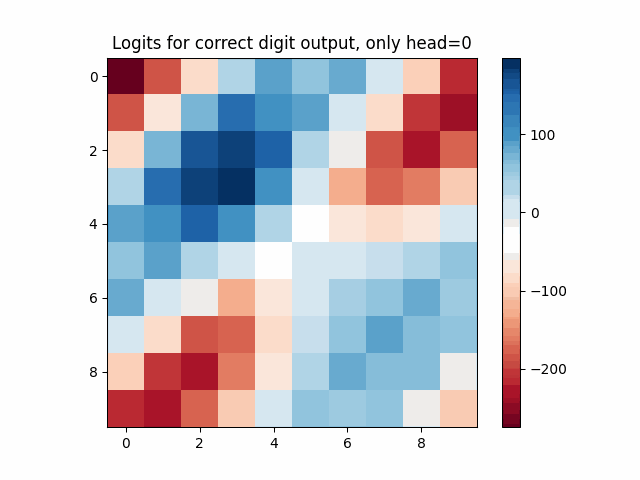

In [188]:
a_dim, b_dim = 10, 10 # a and b are digits
# And now we want a heat map of, for a single head,
# a by b with color corresponding to how strongly
# that head predicted the correct output
head_probs  = F.softmax(torch.stack(ablation_scores), dim=3).cpu().detach().numpy()
head_probs  = torch.stack(ablation_scores).cpu().detach().numpy()
nice_scores = head_probs.reshape((model.cfg.n_heads, a_dim, b_dim, model.cfg.n_ctx, 10))
probabilities_subset = nice_scores[head_idx, :, :, position_idx, :]
probs_by_head = np.zeros((model.cfg.n_heads, 10, 10)) # (head, a, b) -> correct probs
for head_idx in range(model.cfg.n_heads):
    for a in range(10):
        for b in range(10):
            c = (a+b)%10
            probs_by_head[head_idx,a,b] = nice_scores[head_idx,a,b,position_idx,c]
images = []
image_path_template = "heatmap_images_heatmap_{}.png"
for head_idx in range(model.cfg.n_heads):
    plt.imshow(probs_by_head[head_idx], cmap='RdBu')#, vmin=-256, vmax=+256)
    plt.colorbar()
    plt.title(f"Logits for correct digit output, only head={head_idx}")
    plt.savefig(image_path_template.format(head_idx))
    plt.close()
    image_path = image_path_template.format(head_idx)
    image = Image.open(image_path)
    images.append(image)

gif_path = "heatmap_animation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
display(IPyImage(filename=gif_path))

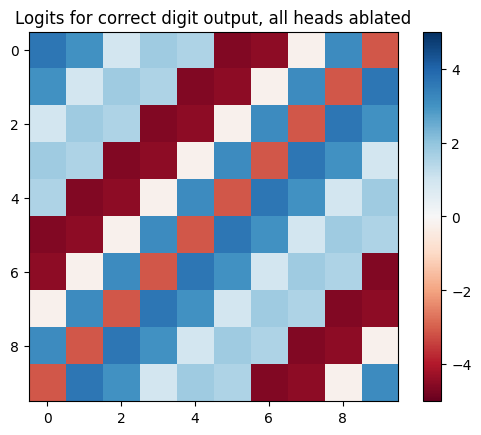

In [198]:
ablation_score_no_attn = get_ablation_score_without_attn(model, one_digit_additions_tokens)
a_dim, b_dim = 10, 10 # a and b are digits

# With all heads ablated, what are the logits for the correct
# digit for every pair in 1-digit addition
nice_scores = ablation_score_no_attn.reshape((a_dim, b_dim, model.cfg.n_ctx, 10))
probs = np.zeros((10, 10)) # (a, b) -> correct probs
for a in range(10):
    for b in range(10):
        c = (a+b)%10
        probs[a,b] = nice_scores[a,b,position_idx,c]
probs.shape

plt.imshow(probs, cmap='RdBu', vmin=-5, vmax=+5)
plt.colorbar()
plt.title(f"Logits for correct digit output, all heads ablated")
plt.show()
plt.close()

/tmp/ipykernel_1660/2363357502.py:22: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



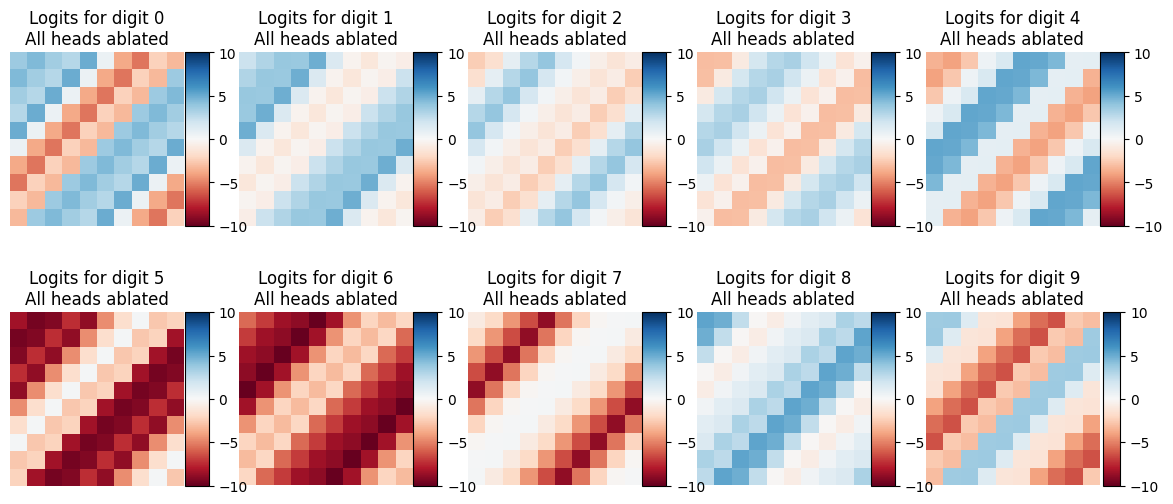

In [290]:
ablation_score_no_attn = get_ablation_score_without_attn(model, one_digit_additions_tokens)
a_dim, b_dim = 10, 10 # a and b are digits
nice_scores = ablation_score_no_attn.reshape((a_dim, b_dim, model.cfg.n_ctx, 10))

# Create a figure and axes with the desired layout
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterate over the charts and plot them in the corresponding axes
for digit, ax in enumerate(axes.flatten()):
    #  # Customize this line with your specific chart data and plot settings
    #ax.set_title(f'Chart {digit+1}')
    logits = np.zeros((10, 10)) # (a, b) -> logit_for_digit
    for a in range(10):
        for b in range(10):
            logits[a,b] = nice_scores[a,b,position_idx,digit]
    im = ax.imshow(logits, cmap='RdBu', vmin=-10, vmax=+10)
    ax.set_title(f"Logits for digit {digit}\nAll heads ablated")
    ax.axis('off')  # Optional: Turn off axis labels and ticks
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    fig.colorbar(im, cax=cax)

plt.tight_layout(pad=4.0)
for digit in range(10):
    digit_chart_pos = fig.axes[-20+digit].get_position()
    dx = 0.001 if digit < 9 else 0.003333333
    w  = 0.02  if digit < 9 else 0.014444444
    fig.axes[-10+digit].set_position(dict(
        x0=digit_chart_pos.x1+dx,
        y0=digit_chart_pos.y0,
        width=w,
        height=digit_chart_pos.height
    ).values())
plt.show()
plt.close()

In [273]:
print(fig.axes[-6].get_position())
print(fig.axes[-1].get_position())
digit = 9
digit_chart_pos = fig.axes[-20+digit].get_position()
fig.axes[-10+digit].set_position(dict(
    x0=digit_chart_pos.x1+0.00213888,
    y0=digit_chart_pos.y0,
    width=0.02*0.7222222,
    height=digit_chart_pos.height
).values())
print(fig.axes[-1].get_position())
0.9574814814814812-0.9558425917037032+0.00044444444

Bbox(x0=0.9574814814814812, y0=0.55680779054917, x1=0.9719259259259255, y1=0.8456966794380585)
Bbox(x0=0.9558425917037032, y0=0.12379374201788002, x1=0.9702870357037032, y1=0.41268263090676854)
Bbox(x0=0.9558425837037032, y0=0.12379374201788002, x1=0.9702870277037032, y1=0.41268263090676854)


0.00208333421777793

/tmp/ipykernel_1660/1754981276.py:35: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



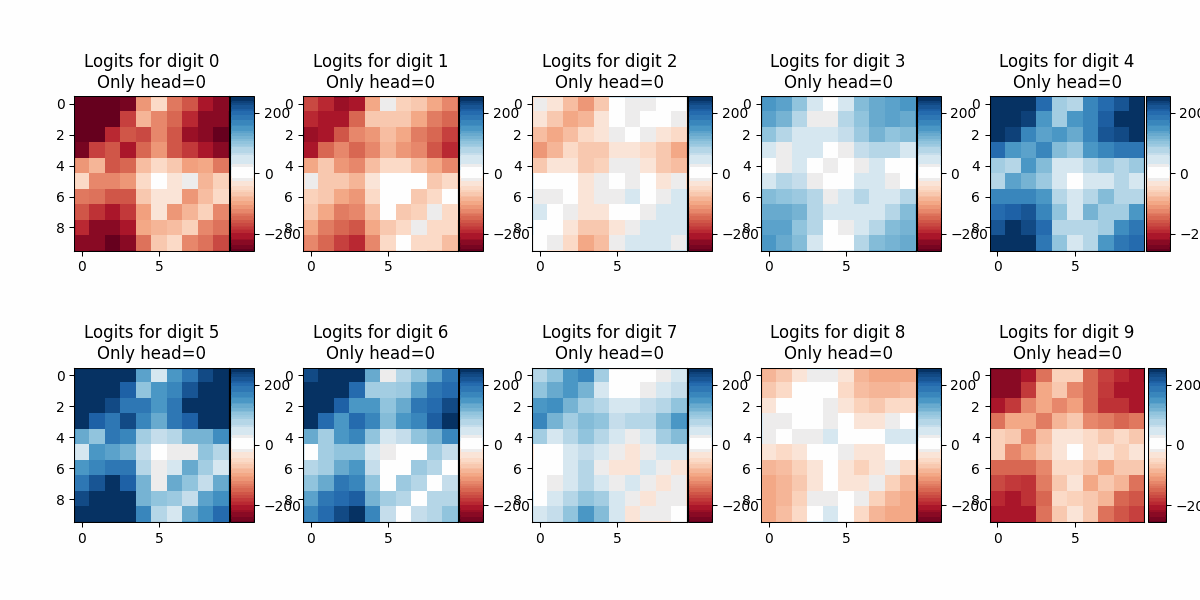

In [288]:
a_dim, b_dim = 10, 10 # a and b are digits
# And now we want a heat map of, for a single head,
# a by b with color corresponding to how strongly
# that head predicted the correct output

head_logits  = torch.stack(ablation_scores).cpu().detach().numpy()
nice_scores = head_logits.reshape((model.cfg.n_heads, a_dim, b_dim, model.cfg.n_ctx, 10))
probabilities_subset = nice_scores[head_idx, :, :, position_idx, :]
probs_by_head = np.zeros((model.cfg.n_heads, 10, 10)) # (head, a, b) -> correct logits
for head_idx in range(model.cfg.n_heads):
    for a in range(10):
        for b in range(10):
            c = (a+b)%10
            probs_by_head[head_idx,a,b] = nice_scores[head_idx,a,b,position_idx,c]
images = []
image_path_template = "heatmap_multi_frame_{}.png"
for head_idx in range(model.cfg.n_heads):
    # Create a figure and axes with the desired layout
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # Iterate over the charts and plot them in the corresponding axes
    for digit, ax in enumerate(axes.flatten()):
        #  # Customize this line with your specific chart data and plot settings
        #ax.set_title(f'Chart {digit+1}')
        logits = np.zeros((10, 10)) # (a, b) -> logit_for_digit
        for a in range(10):
            for b in range(10):
                logits[a,b] = nice_scores[head_idx,a,b,position_idx,digit]
        im = ax.imshow(logits, cmap='RdBu', vmin=-256, vmax=+256)
        ax.set_title(f"Logits for digit {digit}\nOnly head={head_idx}")
        #ax.axis('off')  # Optional: Turn off axis labels and ticks
        cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
        fig.colorbar(im, cax=cax)

    plt.tight_layout(pad=4.0)
    for digit in range(10):
        digit_chart_pos = fig.axes[-20+digit].get_position()
        dx = 0.001 if digit < 9 else 0.003333333
        w  = 0.02  if digit < 9 else 0.014444444
        fig.axes[-10+digit].set_position(dict(
            x0=digit_chart_pos.x1+dx,
            y0=digit_chart_pos.y0,
            width=w,
            height=digit_chart_pos.height
        ).values())
    plt.savefig(image_path_template.format(head_idx))
    plt.close()

    image_path = image_path_template.format(head_idx)
    image = Image.open(image_path)
    images.append(image)

gif_path = "heatmap_multi_animation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
display(IPyImage(filename=gif_path))

In [293]:
for name, value in model.named_parameters():
    print(f"{name}: {value.shape}")

embed.W_E: torch.Size([12, 128])
pos_embed.W_pos: torch.Size([19, 128])
blocks.0.attn.W_Q: torch.Size([32, 128, 2])
blocks.0.attn.W_K: torch.Size([32, 128, 2])
blocks.0.attn.W_V: torch.Size([32, 128, 2])
blocks.0.attn.W_O: torch.Size([32, 2, 128])
blocks.0.attn.b_Q: torch.Size([32, 2])
blocks.0.attn.b_K: torch.Size([32, 2])
blocks.0.attn.b_V: torch.Size([32, 2])
blocks.0.attn.b_O: torch.Size([128])
unembed.W_U: torch.Size([128, 10])
unembed.b_U: torch.Size([10])


import plotly.io as pio
pio.renderers.default = "png"

## See how the embed + pos embed projects into attention space for each head

### Get all the layers of the model

In [426]:
model_named_params = dict(model.named_parameters())
W_E   = model_named_params['embed.W_E']
W_pos = model_named_params['pos_embed.W_pos']

W_Q   = model_named_params['blocks.0.attn.W_Q']
W_K   = model_named_params['blocks.0.attn.W_K']
W_O   = model_named_params['blocks.0.attn.W_O']
W_V   = model_named_params['blocks.0.attn.W_V']

b_Q   = model_named_params['blocks.0.attn.b_Q']
b_K   = model_named_params['blocks.0.attn.b_K']
b_O   = model_named_params['blocks.0.attn.b_O']
b_V   = model_named_params['blocks.0.attn.b_V']

W_U   = model_named_params['unembed.W_U']
b_U   = model_named_params['unembed.b_U']

### First, let's see if we can figure out a non-confusing way to show the entire projection for a single head for K in a single chart

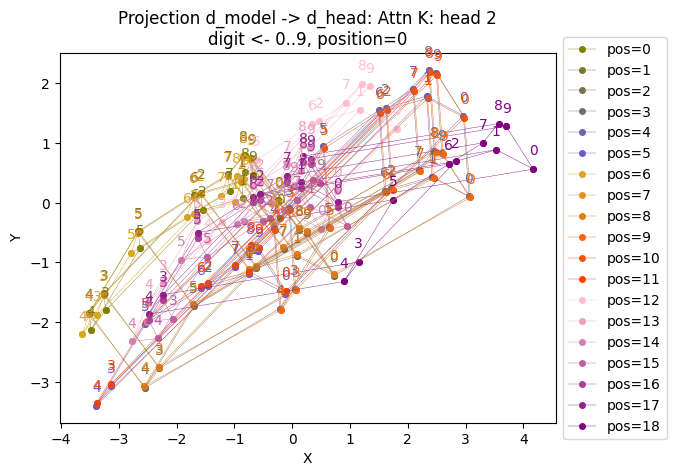

In [422]:
head     = 2

# Extract the x and y coordinates from the tensors W_K and b_K
# for every head, position, and digit

proj_k = np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head))
for position in range(model.cfg.n_ctx):
    proj_k_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_K[head,:,:] + b_K[head, np.newaxis,:])
    proj_k[head,position,:,:] = proj_k_pos.cpu().detach().numpy()

def get_color_for_position(position):
    if position < n_digits:
        # Positions in first number (a) range from green to blue
        start_color, end_color = [0.5, 0.5, 0.0], [0.42, 0.36, 0.80]
        frac = position / (n_digits - 1)
    elif position < 2*n_digits:
        # Positions in second number (b) range from gold to red
        start_color, end_color = [0.85, 0.65, 0.13], [1.0, 0.25, 0.0]
        frac = (position - n_digits) / (n_digits - 1)
    else:
        # Positions in result number (a+b) range from pink to purple
        start_color, end_color = [1, 0.75, 0.80], [0.5, 0.0, 0.5]
        frac = (position - 2*n_digits) / n_digits

    color = [(b*frac+a*(1-frac)) for a, b in zip(start_color, end_color)]
    return color

# Create a scatter plot
plt.scatter([], [], c='b', marker='o')    
for position in range(model.cfg.n_ctx):
    x = proj_k[head,position,:,0]
    y = proj_k[head,position,:,1]

    color = get_color_for_position(position)

    # Add labels for each point to show the order
    for digit in range(10):
        plt.plot(
            proj_k[head,position,[digit,(digit+1)%10],0],
            proj_k[head,position,[digit,(digit+1)%10],1],
            marker="o",
            markersize=4,
            linewidth=0.3,
            color=color,
            **(dict(label=f"pos={position}") if digit == 0 else {})
        )
        plt.annotate(
            str(digit),
            proj_k[head,position,digit,:],
            textcoords="offset points",
            xytext=(0,10),
            ha='center',
            color=color
        )

for digit in range(10):
    for position in range(model.cfg.n_ctx):
        if position not in [0, n_digits, n_digits*2]:
            color = get_color_for_position(position - 0.5)
            plt.plot(
                proj_k[head,[position-1,position],digit,0],
                proj_k[head,[position-1,position],digit,1],
                markersize=4,
                linewidth=0.3,
                color=color,
            )

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Projection d_model -> d_head: Attn K: head {head}\ndigit <- 0..9, position=0')

# Display the plot
plt.show()

That chart is pretty confusing.

### Hopefully better charts

Let's do it with 2 charts for K (and then another 2 each for Q, V, and B)

In [470]:
proj = dict(
    k=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head)),
    q=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head)),
    o=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head)),
    v=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head))
)
for head in range(model.cfg.n_heads):
    for position in range(model.cfg.n_ctx):
        proj_k_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_K[head,:,:] + b_K[head, np.newaxis,:])
        proj_q_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_Q[head,:,:] + b_Q[head, np.newaxis,:])
        proj_v_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_V[head,:,:] + b_V[head, np.newaxis,:])
        # Not sure I have the math right here for how to work backwards
        # from unembed and W_O to attn space
        proj_o_pos = ((W_O[head,:,:]@(W_U[:,:10]) + b_O[head, np.newaxis])).T
        proj['k'][head,position,:,:] = proj_k_pos.cpu().detach().numpy()
        proj['q'][head,position,:,:] = proj_q_pos.cpu().detach().numpy()
        proj['v'][head,position,:,:] = proj_v_pos.cpu().detach().numpy()
        proj['o'][head,position,:,:] = proj_o_pos.cpu().detach().numpy()

Confirm that the shapes of the projections make sense (n_heads, d_pos, d_vocab, d_head)

In [438]:
{k: p.shape for k, p in proj.items()}

{'k': (32, 19, 10, 2),
 'q': (32, 19, 10, 2),
 'o': (32, 19, 10, 2),
 'v': (32, 19, 10, 2)}

In [487]:
def show_head_projections(head):
    fig, axes = plt.subplots(2, 4, figsize=(12, 9))

    for ix, param_name in enumerate("qkvo"):
        param_proj = proj[param_name]

        # Plot the position, for this head, of all projections of q/k/v/o
        # into attention space
        #  - for each digit for position 0
        #  - for each position for digit 0

        # Start with digits
        ax = axes[0][ix]
        ax.set_title(f'Head {head}: attn.{param_name.upper()}\nd_model -> d_head\ndigit 0..9, pos=0')
        sc = ax.scatter([], [], c='b', marker='o')
        axplt = ax.plot(
            param_proj[head,0,[d%10 for d in range(11)],0],
            param_proj[head,0,[d%10 for d in range(11)],1],
            marker="o",
            markersize=4,
            color=[0.5,0.5,0.5],
            linewidth=0.3,
        )
        for digit in range(10):
            ax.annotate(
                str(digit),
                param_proj[head,0,digit,:],
                textcoords="offset points",
                xytext=(0,5),
                ha='center',
            )

        # And then do positions
        ax = axes[1][ix]
        ax.set_title(f'Head {head}: attn.{param_name.upper()}\nd_model -> d_head\ndigit 0, pos=0..{model.cfg.n_ctx}')
        axplt = ax.plot(
            param_proj[head,:,0,0],
            param_proj[head,:,0,1],
            marker="o",
            markersize=4,
            color=[0.5,0.5,0.5],
            linewidth=0.3,
        )
        for position in range(model.cfg.n_ctx):
            if position < n_digits:
                pos_name = f'a:{position}'
                color = [0.5, 0.5, 0.0]
            elif position < 2*n_digits:
                pos_name = f'b:{position-n_digits}'
                color = [1.0, 0.25, 0.0]
            else:
                pos_name = f'b:{position-n_digits}'
                color = [1, 0.75, 0.80]

            ax.annotate(
                str(position),
                param_proj[head,position,0,:],
                textcoords="offset points",
                xytext=(0,5),
                ha='center',
                color=color
            )

    plt.show()
    plt.close()

In [492]:
interact(
    show_head_projections,
    head=widgets.IntSlider(min=0, max=model.cfg.n_heads-1, step=1, value=0)
)

interactive(children=(IntSlider(value=0, description='head', max=31), Output()), _dom_classes=('widget-interac…

<function __main__.show_head_projections(head)>

In [13]:
#doing some interpretability in terms of the Q-K matrix
def is_psd(mat):
    return bool((mat == mat.T).all())
#Test:


print(W_QK[0][0].shape)
W_OK_head_1 = W_QK[0][0]

#since Q_K is not positive definite, it does not correspond to a polytone

NameError: name 'W_QK' is not defined